# Recurrent network and dynamics activity
In this activity you will train a LSTM network to approximate a certain nonlinear dynamic system. The system is a van der Pol oscillator. It has has two state variables, which we can call $x_1$ and $x_2$. The state variables change over time in a way that depends on the state variables themselves. Specifically, 
\begin{align*}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= \mu (1-x_1^2) x_2 - x_1 
\end{align*}
where $\mu>0$ is a parameter. Trajectories of the state variables can be plotted in a flow field, like so ... 

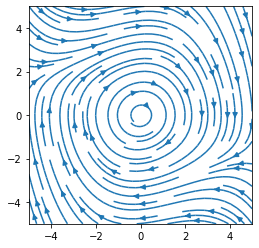

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_flow_field():
    x1 = np.linspace(-5, 5, 20)
    x2 = np.linspace(-5, 5, 20)
    X1, X2 = np.meshgrid(x1, x2)

    mu = 0.1
    dx1 = X2
    dx2 = mu * (1-X1**2) * X2 - X1

    fig = plt.figure(figsize=(4, 4))
    plt.streamplot(X1, X2, dx1, dx2, density=1)

plot_flow_field()
plt.show()

This system is a kind of limit-cycle oscillator. It is an oscillator because the state-variable trajectories go around in loops. It is a limit-cycle oscillator because all of its trajectories (starting from any state) converge to the same loop (called the limit cycle). Trajectories starting near the centre gradually spiral out while those starting farther out gradually spiral in until they all end up on the same cycle. 

To simulate a single trajectory of the system from a given starting state, we can use a standard differential equation solver from Scipy. To do this, we have to implement the right-hand side of the dynamic equations as a Python function. Let's do that and plot a state trajectory two seconds long starting from a random state. We will overlay it on the flow field to confirm that the trajectory follows the flow field.   

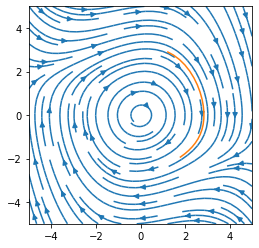

In [2]:
from scipy.integrate import solve_ivp

def van_der_pol_dynamics(t, x):
    """    
    :param t: time (not used, but the solver expects a function with this argument)  
    :param x: state vector 
    :return: state derivative vector 
    """

    mu = 0.1
    dx1 = x[1]
    dx2 = mu * (1 - x[0] ** 2) * x[1] - x[0]
    return [dx1, dx2]

x0 = -5 + 10*np.random.rand(2)
solution = solve_ivp(van_der_pol_dynamics, [0, 2], x0, max_step=.1)

plot_flow_field()
plt.plot(solution.y[0,:], solution.y[1,:])
plt.show()

We will train a LSTM neural network to approximate these dynamics. To do this we will need batches of random example trajectories. The following code will produce those. 

In [3]:
def get_random_trajectory():
    """
    :return: a van der Pol trajectory from a random initial state
    """
    dt = .1
    T = 2
    x0 = -5 + 10*np.random.rand(2)
    solution = solve_ivp(van_der_pol_dynamics, [0, T], x0, max_step=dt)

    # Here we do some extra work to make sure all trajectories have the same 
    # number of samples (solve_ivp doesn't guarantee that). 
    times = np.linspace(0, T, int(T/dt)+1)
    trajectory = np.zeros((2,len(times)))
    trajectory[0,:] = np.interp(times, solution.t, solution.y[0,:])
    trajectory[1,:] = np.interp(times, solution.t, solution.y[1,:])

    return trajectory



def get_minibatch(n):
    """
    :param n: number of examples in minibatch
    :return: minibatch of van der Pol trajectories from random initial states
    """
    inputs = []
    trajectories = []
    for i in range(n):
        trajectory = get_random_trajectory()
        x0 = trajectory[:, 0]
        input = np.zeros_like(trajectory)
        input[:,0] = x0
        inputs.append(input.T)
        trajectories.append(trajectory.T)
    inputs = np.array(inputs).swapaxes(0, 1) # axis order: [sequence, minibatch, elements]
    trajectories = np.array(trajectories).swapaxes(0, 1)
    return torch.Tensor(inputs), torch.Tensor(trajectories)


We have set this up so that the input to the network in the first step is the starting state and the target is the full trajectory. 
Now we will make an LSTM network using a torch.nn.LSTM layer for dynamics and a torch.nn.Linear layer to decode the two-dimensional state from the network's hidden variables. 

In [4]:
import torch
import torch.nn as nn

class LSTMNetwork(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_dim):
        super(LSTMNetwork, self).__init__()
        #TODO: complete this method 
        self.lstm= nn.LSTM(input_dim, hidden_dim)
        self.output= nn.Linear(hidden_dim, target_dim)

    def forward(self, input):
        #TODO: complete this method 
        x,hidden= self.lstm(input)
        return self.output(x)



Now let's make one of these networks and train it to be a van der Pol oscillator. 

In [5]:
import torch.optim as optim

loss_function = nn.MSELoss()
# TODO: create a network with 20 hidden units  
model= LSTMNetwork(2,20,2) # (input (2D state), hidden, target (2D state))
# TODO: create a SGD optimizer with learning rate 0.05
optimizer= optim.SGD(model.parameters(), lr=0.05) #stochastic gradient descent (calculae in batches, not entire training set, more efficient) 

running_loss = 0
for sample in range(2000):
    model.zero_grad()

    initial_conditions, trajectories = get_minibatch(20)

    #TODO: run the model and calculate the loss (use the variable name "loss") 
    output= model(initial_conditions)
    loss= loss_function(output, trajectories)

    loss.backward()

    # calculate and periodically loss that is smoothed over time 
    running_loss = .9*running_loss + .1*loss.item()
    if sample % 50 == 49:
        print('Batch #{}  Loss {}'.format(sample+1, running_loss))
    optimizer.step()


Batch #50  Loss 6.10921059047568
Batch #100  Loss 6.147892865735761
Batch #150  Loss 5.669099262066274
Batch #200  Loss 1.704624890400724
Batch #250  Loss 0.8232143501454867
Batch #300  Loss 0.9094671242524879
Batch #350  Loss 0.7943613352323083
Batch #400  Loss 0.6117821864925546
Batch #450  Loss 0.7669538341029796
Batch #500  Loss 0.5542125756356802
Batch #550  Loss 0.31819692301404323
Batch #600  Loss 0.3315088617858788
Batch #650  Loss 0.39557329771343186
Batch #700  Loss 0.24636329737042734
Batch #750  Loss 0.3100866951642375
Batch #800  Loss 0.16442286963404318
Batch #850  Loss 0.19815124554661612
Batch #900  Loss 0.13241751226303392
Batch #950  Loss 0.22094921147247853
Batch #1000  Loss 0.22980263221663005
Batch #1050  Loss 0.23253729073671964
Batch #1100  Loss 0.11203022070601894
Batch #1150  Loss 0.20683944520590228
Batch #1200  Loss 0.10182690053255988
Batch #1250  Loss 0.122473349564933
Batch #1300  Loss 0.16759767246601462
Batch #1350  Loss 0.092023003065164
Batch #1400  Lo

Finally we sould see how well the network does at pretending to be a van der Pol oscillator. Plot the flow field again along with trajectories from one minibatch. 

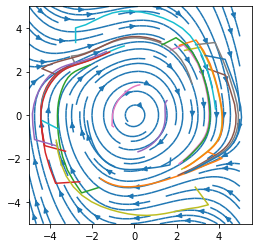

In [6]:
plot_flow_field()

initial_conditions, trajectories = get_minibatch(20)
output = model(initial_conditions).detach().numpy()
for i in range(output.shape[1]):
    trajectory = output[:,i,:]
    plt.plot(trajectory[:,0], trajectory[:,1])
plt.show()


The network struggles at the beginning of a trajectory. This will improve if you train the network for longer. 